In [3]:
import sys; sys.path.append("../")
from src.GeneratingModels import PreferentialAttachmentModel
from src.SimulatedReactionGraph import SimulatedReactionGraph
from src.KineticSolver import KineticSolver
from src import constants
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


In [44]:
import os 

def all_graph_files():
    ajr = []
    parent = "../data/simulated"
    for dirname in os.listdir(parent):
        p = os.path.join(parent, dirname)
        for fname in os.listdir(p):
            ajr.append(os.path.join(p, fname))
    return ajr

def compare_atol(path: str, atols):
    g = SimulatedReactionGraph.from_file(path)
    solver = KineticSolver(g)
    iconcs = [1 if s in g.origin else 0 for s in g.get_species()]
    data = []
    for atol in atols:
        print("running", atol)
        kwds = {"ss_threshold": 1e-6, "atol": atol, "rtol": 1e-3}
        ajr = {"path": path, "atol": atol}
        solver.solve_kinetics(iconcs, **kwds)
        df = solver.concentrations_df()
        ajr["negative_concs"] = df.map(lambda x: 1 if x < - kwds["atol"] else 0).sum().sum()
        sp = df.iloc[-1, :].idxmax()
        ajr["top_specie"] = sp
        ajr["top_specie_conc"] = df[sp].iloc[-1]
        df = solver.rates_df()
        rxn = df.max(axis=0).idxmax()
        ajr["top_rxn"] = rxn
        ajr["max_rate"] = df[rxn].max()
        data.append(ajr)
    return data

In [46]:
paths = np.random.choice(all_graph_files(), 10, replace=False)
atols = [1e-10, 1e-15, 1e-20, 1e-25]
data = []
for path in paths:
    print(path)
    data += compare_atol(path, atols)
    df = pd.DataFrame(data)
    df.to_csv("../results/atol.csv")
df

../data/simulated/s25r2500/15.json
running 1e-10
running 1e-15
running 1e-20
running 1e-25
../data/simulated/s50r5000/7.json
running 1e-10
running 1e-15
running 1e-20
running 1e-25
../data/simulated/s50r1000/10.json
running 1e-10
running 1e-15
running 1e-20
running 1e-25
../data/simulated/s50r5000/24.json
running 1e-10
running 1e-15
running 1e-20
running 1e-25
../data/simulated/s25r2500/18.json
running 1e-10
running 1e-15
running 1e-20
running 1e-25
../data/simulated/s50r1000/17.json
running 1e-10
running 1e-15
running 1e-20
running 1e-25


KeyboardInterrupt: 

In [36]:
# path = "../data/simulated/s25r1000/4.json"
path = "../data/simulated/s100r5000/4.json"
g = SimulatedReactionGraph.from_file(path)
solver = KineticSolver(g)
iconcs = [1 if s in g.origin else 0 for s in g.get_species()]
solver_kwds = [
    {"ss_threshold": 1e-6, "atol": 1e-10, "rtol": 1e-3},
    {"ss_threshold": 1e-6, "atol": 1e-15, "rtol": 1e-3},
    {"ss_threshold": 1e-6, "atol": 1e-20, "rtol": 1e-3},
    {"ss_threshold": 1e-6, "atol": 1e-25, "rtol": 1e-3},
]
data = []
for i, kwds in enumerate(solver_kwds):
    ajr = {}
    solver.solve_kinetics(iconcs, **kwds)
    df = solver.concentrations_df()
    ajr["negative_concs"] = df.map(lambda x: 1 if x < - kwds["atol"] else 0).sum().sum()
    sp = df.iloc[-1, :].idxmax()
    ajr["top_specie"] = sp
    df = solver.rates_df()
    rxn = df.max(axis=0).idxmax()
    ajr["top_rxn"] = rxn
    ajr["max_rate"] = df[rxn].max()
    # plot the most negative specie
    # sp = df.min(axis=0).idxmin()
    # plt.plot(df.index, - df[sp], label=i)
    ajr.update(kwds)
    data.append(ajr)
# plt.yscale('log')
# plt.legend()
pd.DataFrame(data)

,negative_concs,top_specie,top_rxn,max_rate,ss_threshold,atol,rtol
0,777,s44,r:s16+s53->s40+s44,7.413457e+20,0.000001,1.000000e-10,0.001
1,183,s44,r:s16+s53->s40+s44,7.413457e+20,0.000001,1.000000e-15,0.001
2,0,s40,r:s16+s53->s40+s44,7.413457e+20,0.000001,1.000000e-20,0.001
3,0,s40,r:s16+s53->s40+s44,7.413457e+20,0.000001,1.000000e-25,0.001


# OLD

In [2]:
def generate_synthetic_graphs(nspeices, nreactions, ngraphs, temperature: float=600) -> List[SimulatedReactionGraph]:
    # make the base model
    model = PreferentialAttachmentModel(
        nspeices, 
        nreactions, 
        specie_energy_dist=constants.SPECIE_ENERGY_DIST
    )
    res = []
    for _ in range(ngraphs):
        g = model.generate_graph()
        g.add_kinetic_data(T=temperature)
        # add "k" property
        for rxn in g.reactions():
            rxn.properties["k"] = np.exp(rxn.properties["logk"])
        res.append(g)
    return res

def solve_kinetics(g: SimulatedReactionGraph, origin: List[str], tstep: float=None):
    solver = KineticSolver(g, "k")
    if origin is None:
        origin = np.random.choice(g.get_species(), 2) # set randomly two origin points
    iconcs = [1 if s in s in origin else 0 for s in g.get_species()]
    if tstep is None:
        tstep  = 1 / np.mean([rxn.properties["k"] for rxn in g.reactions()]) # estimate best step size from data
    nsteps = 200 # seems like legit value to get to steady state
    solver.solve_kinetics(nsteps * tstep, tstep, iconcs)
    return solver

def plot_solution(solver: KineticSolver):
    concs = solver.concentrations_df()
    for c in concs:
        plt.plot(concs.index, concs[c])
    plt.yscale("log")

def percolate_reactions(g: SimulatedReactionGraph, n: int, origin: List[str]) -> SimulatedReactionGraph:
    ajr = g.copy()
    counter = 0
    while counter < n:
        if len(ajr.get_reactions()) == 0:
            break
        node = np.random.choice(ajr.get_reactions())
        ajr.remove_reaction(node)
        counter += 1
    # making sure the graph has the origin species
    if origin is not None:
        for s in origin:
            if not s in ajr.g:
                ajr.g.add_node(s, energy=None)
    return ajr

def percolate_species(g: SimulatedReactionGraph, n: int) -> SimulatedReactionGraph:
    ajr = g.copy()
    counter = 0
    while counter < n:
        if len(ajr.get_species()) == 0:
            break
        node = np.random.choice(ajr.get_species())
        ajr.remove_specie(node)
        counter += 1
    return ajr

def compare_solutions(osolver: KineticSolver, rsolver: KineticSolver, origin: List[str]) -> dict:
    """Compare different kinetic solveres of original (o) and reduced/percolated (r) graphs"""
    odf = osolver.concentrations_df().map(lambda x: np.log(x) if x > 0 else -700).dropna()
    rdf = rsolver.concentrations_df().map(lambda x: np.log(x) if x > 0 else -700).dropna()
    # compare concentration values - profile + ss value
    profile_err = 0
    ss_err = 0
    for sp in rdf.columns:
        # remove origin nodes to avoid bias
        # if sp in origin: 
        #     continue
        f = interp1d(rdf.index, rdf[sp], bounds_error=False)
        profile_err += np.sum(np.abs(odf[sp] - f(odf.index)))
        oss = odf[sp].iloc[-1]
        rss = rdf[sp].iloc[-1]
        ss_err += np.abs(oss - rss)
    # calculate average
    nsps = len(rdf.columns)
    profile_err = profile_err / (nsps * len(odf.index))
    ss_err = ss_err / nsps
    # normalize by average conc values
    return {"profile": profile_err / np.mean(odf.abs().values), "ss": ss_err / np.mean(odf.abs().values)}



In [5]:
data = []
nsteps = 20
nreps = 5
for nreactions in [1000, 2500, 5000]:
    print("N REACTIONS", nreactions)
    ogs = generate_synthetic_graphs(50, nreactions, nreps)
    step = nreactions / nsteps
    for rep, og in enumerate(ogs):
        print("REP", rep + 1)
        origin = np.random.choice(og.get_species(), 2)
        og_solver = solve_kinetics(og, origin)
        data.append({
                "rep": rep + 1,
                "step": 0,
                "n_percolated": 0,
                "og_reactions": nreactions,
                "reactions": len(og.get_reactions()),
                "species": len(og.get_species()),
                "graph": og,
                "solver": og_solver
            })
        rg = og
        for i in range(1, nsteps):
            rg = percolate_reactions(rg, step, origin=origin) 
            rg_solver = solve_kinetics(rg, origin)
            d = {
                "rep": rep + 1,
                "step": i,
                "n_percolated": step,
                "og_reactions": nreactions,
                "reactions": len(rg.get_reactions()),
                "species": len(rg.get_species()),
                "graph": rg,
                "solver": rg_solver
            }
            d.update(compare_solutions(osolver=og_solver, rsolver=rg_solver, origin=origin))
            data.append(d)
df = pd.DataFrame(data)

N REACTIONS 1000
REP 1


/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


REP 2
REP 3
REP 4
REP 5


/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


N REACTIONS 2500
REP 1


/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


REP 2
REP 3


/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


REP 4


/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


REP 5
N REACTIONS 5000
REP 1


/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


SOLVER WAS NOT SUCCESSFUL
SOLVER WAS NOT SUCCESSFUL
REP 2
REP 3


/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


REP 4


/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


REP 5


In [46]:
df

,rep,step,n_percolated,og_reactions,reactions,species,graph,solver,profile,ss
0,1,19,50.0,1000,0,1,<src.SimulatedReactionGraph.SimulatedReactionG...,<src.KineticSolver.KineticSolver object at 0x7...,NaN,NaN
1,1,1,50.0,1000,950,50,<src.SimulatedReactionGraph.SimulatedReactionG...,<src.KineticSolver.KineticSolver object at 0x7...,0.077625,0.072763
2,1,2,50.0,1000,900,50,<src.SimulatedReactionGraph.SimulatedReactionG...,<src.KineticSolver.KineticSolver object at 0x7...,0.146737,0.168473
3,1,3,50.0,1000,850,50,<src.SimulatedReactionGraph.SimulatedReactionG...,<src.KineticSolver.KineticSolver object at 0x7...,0.161873,0.171342
4,1,4,50.0,1000,800,50,<src.SimulatedReactionGraph.SimulatedReactionG...,<src.KineticSolver.KineticSolver object at 0x7...,0.181701,0.220858
...,...,...,...,...,...,...,...,...,...,...
295,5,15,250.0,5000,944,49,<src.SimulatedReactionGraph.SimulatedReactionG...,<src.KineticSolver.KineticSolver object at 0x7...,0.000000,0.000000
296,5,16,250.0,5000,694,49,<src.SimulatedReactionGraph.SimulatedReactionG...,<src.KineticSolver.KineticSolver object at 0x7...,0.000000,0.000000
297,5,17,250.0,5000,337,48,<src.SimulatedReactionGraph.SimulatedReactionG...,<src.KineticSolver.KineticSolver object at 0x7...,0.000000,0.000000
298,5,18,250.0,5000,55,37,<src.SimulatedReactionGraph.SimulatedReactionG...,<src.KineticSolver.KineticSolver object at 0x7...,0.000000,0.000000


## Analyze Percolation

In [2]:
# read data from large-scale simulation
original_df = pd.read_csv("../results/percolation.csv")
original_df = original_df.drop(columns=["Unnamed: 0"])
# add og specie data
ogspeices = []
curr = 0
for n_species, total_percolated in original_df[["n_species", "total_percolated"]].values:
    if total_percolated == 0:
        curr = n_species
    ogspeices.append(curr)
original_df["og_species"] = ogspeices
# rebuild df to include all steps till 0 reactions
new_data = []
for row in original_df.to_dict(orient="records"):
    if row["n_reactions"] > 0:
        new_data.append(row)
    else:
        d = row.copy()
        while True:
            if d["total_percolated"] == d["og_reactions"]:
                break
            d = d.copy()
            d["total_percolated"] += d["percolation_step_size"]
            new_data.append(d)
print(original_df)
original_df = pd.DataFrame(new_data)
original_df

       n_reactions  n_species  ss_covered_rate  mean_covered_rate  \
0             2500        100     1.000000e+00       1.000000e+00   
1             2480        100     1.000000e+00       1.000000e+00   
2             2460        100     1.000000e+00       1.000000e+00   
3             2440        100     1.000000e+00       1.000000e+00   
4             2420        100     1.000000e+00       1.000000e+00   
...            ...        ...              ...                ...   
19798          112         24     7.540957e-01       7.555098e-01   
19799           92         24     7.540957e-01       7.555098e-01   
19800           56         22     7.338595e-27       3.673857e-27   
19801           23         19     7.338595e-27       3.673857e-27   
19802            0          0     0.000000e+00       0.000000e+00   

       min_covered_rate  og_reactions  rep  percolation_step_size  \
0              1.000000          2500   28                     20   
1              1.000000          

,n_reactions,n_species,ss_covered_rate,mean_covered_rate,min_covered_rate,og_reactions,rep,percolation_step_size,total_percolated,og_species
0,2500,100,1.000000e+00,1.000000e+00,1.000000,2500,28,20,0,100
1,2480,100,1.000000e+00,1.000000e+00,1.000000,2500,28,20,20,100
2,2460,100,1.000000e+00,1.000000e+00,1.000000,2500,28,20,40,100
3,2440,100,1.000000e+00,1.000000e+00,1.000000,2500,28,20,60,100
4,2420,100,1.000000e+00,1.000000e+00,1.000000,2500,28,20,80,100
...,...,...,...,...,...,...,...,...,...,...
20720,92,24,7.540957e-01,7.555098e-01,0.754096,2500,16,20,2400,25
20721,56,22,7.338595e-27,3.673857e-27,0.000000,2500,16,20,2420,25
20722,23,19,7.338595e-27,3.673857e-27,0.000000,2500,16,20,2440,25
20723,0,0,0.000000e+00,0.000000e+00,0.000000,2500,16,20,2480,25


In [ ]:
df = original_df.copy()
norm_factor = 50
alpha = 0.5
size = 10
species = norm_factor
print(df["og_reactions"].unique())
colors = ["r", "g", "b"]
for color, n_reactions in zip(colors, df["og_reactions"].unique()):
    ajr = df[(df["og_reactions"] == n_reactions) & (df["og_species"] == species)][[c for c in df.columns if c not in ["solver", "graph"]]].sort_values("total_percolated")
    for rep in ajr["rep"].unique():
        x = ajr[ajr["rep"] == rep]
        rxn_diff = x["percolation_step_size"] + x["n_reactions"].diff()
        plt.figure()
        # plt.scatter((n_reactions - x["total_percolated"]) / norm_factor, x["n_reactions"] / norm_factor, marker="o", s=size, c=color, alpha=alpha)
        # plt.scatter(x["total_percolated"] / x["og_reactions"], rxn_diff, marker="o", s=size, c=color, alpha=alpha)
        plt.scatter(x["total_percolated"], x["og_reactions"] - x["n_reactions"], marker="o", s=size, c=color, alpha=alpha)
    # avg = ajr.groupby(["total_percolated"]).mean()
    # plt.scatter((n_reactions - avg.index) / norm_factor, avg["n_reactions"] / norm_factor, marker="o", s=size, c=color, alpha=alpha, label=f"N={n_reactions}")
    # plt.plot((n_reactions - avg.index) / norm_factor, avg["n_reactions"] / norm_factor, color=color, label=f"N={n_reactions}")
    # plt.plot((n_reactions - avg.index) / norm_factor, (n_reactions - avg.index) / norm_factor, linestyle="--", color="k")
# plt.legend(loc="lower right")
# plt.xlim(0, 20)
# plt.ylim(0, 20)

In [ ]:
def conc_diff(osolver: KineticSolver, rsolver: KineticSolver):
    odf = osolver.concentrations_df()
    origin = [sp for sp in odf.columns if odf.iloc[0, :][sp] > 0]
    odf = osolver.concentrations_df().drop(columns=origin).apply(lambda row: row / np.sum(row))
    rdf = rsolver.concentrations_df().drop(columns=origin).apply(lambda row: row / np.sum(row))
    # compare concentration values - profile + ss value
    profile_err = 0
    ss_err = 0
    for sp in rdf.columns:
        f = interp1d(rdf.index, rdf[sp], bounds_error=False)
        profile_err += np.sum(np.abs((odf[sp] - f(odf.index))))
        oss = odf[sp].iloc[-1]
        rss = rdf[sp].iloc[-1]
        ss_err += np.abs((oss - rss))
    # calculate average
    nsps = len(rdf.columns)
    profile_err = profile_err / (nsps * len(odf.index))
    ss_err = ss_err / nsps
    # normalize by average conc values
    return {"r_profile": profile_err, "r_ss": ss_err}

def get_properties(df: pd.DataFrame):
    values = []
    for row in df.to_dict(orient="records"):
        if row["step"] > 0:
            rgsolver = row["solver"]
            ogsolver = df[(df["og_reactions"] == row["og_reactions"]) & (df["rep"] == row["rep"]) & (df["step"] == 0)]["solver"].values[0]
            values.append(conc_diff(ogsolver, rgsolver))
        else:
            values.append({"r_profile": 0, "r_ss": 0})
    return values


colors = ["r", "g", "b"]
for color, n_reactions in zip(colors, df["og_reactions"].unique()):
    # if n_reactions in [1000, 2500]:
    #     continue
    ajr = df[(df["og_reactions"] == n_reactions) & (df["reactions"] > 0)].sort_values("step")
    # add conc diff
    values = get_properties(ajr)
    # insert to df
    ajr = ajr.drop(columns=["solver", "graph"])
    ajr["ss"] = [d["r_ss"] for d in values]
    ajr["profile"] = [d["r_profile"] for d in values]
    for rep in ajr["rep"].unique():
        x = ajr[ajr["rep"] == rep]
        plt.scatter(x["removed"] / n_reactions, x["profile"], marker="o", c=color, alpha=0.1)
    avg = ajr.groupby(["removed"]).mean()
    plt.plot(avg.index / n_reactions, avg["profile"], marker="o", color=color, alpha=1, label=f"N={n_reactions}")
# plt.legend(loc="upper right")
plt.xlabel("% removed reactions")
plt.ylabel("Relative Steady State Error")
plt.yscale("log")

N REACTIONS 2500
N REACTIONS 5000
N REACTIONS 1000


Text(0, 0.5, 'Covered Rate')

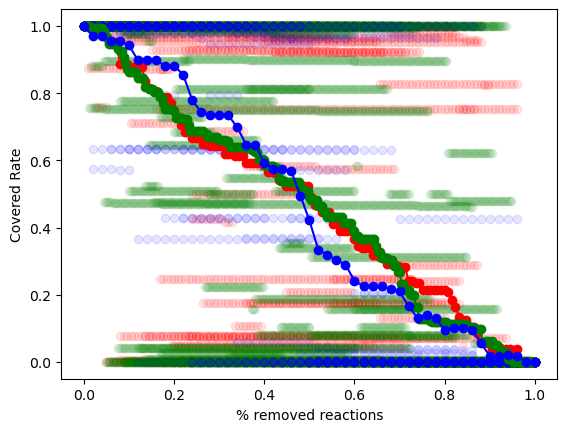

In [10]:
def covered_rate(rates: pd.DataFrame, rg: SimulatedReactionGraph):
    covered = rates.loc[:, rg.get_reactions()].sum(axis=1).values / rates.sum(axis=1).values
    return {"min": np.min(covered), "mean": np.mean(covered), "ss": covered[-1]}

def get_coverage(df: pd.DataFrame):
    values = []
    rates_dict = {}
    for n_rxns in df["og_reactions"].unique():
        rates_dict[n_rxns] = {}
        for rep in df["rep"].unique():
            ogsolver = df[(df["og_reactions"] == n_rxns) & (df["rep"] == rep) & (df["step"] == 0)]["solver"].values[0]
            rates_dict[n_rxns][rep] = ogsolver.get_rates()
    for i, row in enumerate(df.to_dict(orient="records")):
        if row["step"] > 0 and row["reactions"] > 0:
            rg = row["graph"]
            rates = rates_dict[row["og_reactions"]][row["rep"]]
            values.append(covered_rate(rates, rg))
        elif row["step"] == 0:
            values.append({"min": 1, "mean": 1, "ss": 1})
        elif row["reactions"] == 0:
            values.append({"min": 0, "mean": 0, "ss": 0})
    return values


colors = ["r", "g", "b"]
for color, n_reactions in zip(colors, df["og_reactions"].unique()):
    print("N REACTIONS", n_reactions)
    ajr = df[(df["og_reactions"] == n_reactions)].sort_values(["rep", "total_percolated"])
    # add conc diff
    for rep in ajr["rep"].unique():
        x = ajr[ajr["rep"] == rep]
        plt.scatter(x["total_percolated"] / n_reactions, x["ss_covered_rate"], marker="o", c=color, alpha=0.1)
    avg = ajr.groupby(["total_percolated"]).mean()
    plt.plot(avg.index / n_reactions, avg["ss_covered_rate"], marker="o", color=color, alpha=1, label=f"N={n_reactions}")
# plt.legend(loc="upper right")
plt.xlabel("% removed reactions")
plt.ylabel("Covered Rate")
# plt.yscale("log")

In [ ]:
df["removed"] = df["step"] * df["n_percolated"]
colors = ["r", "g", "b"]
for color, n_reactions in zip(colors, df["og_reactions"].unique()):
    ajr = df[df["og_reactions"] == n_reactions][[c for c in df.columns if c not in ["solver", "graph"]]].sort_values("step")
    for rep in ajr["rep"].unique():
        x = ajr[ajr["rep"] == rep]
        y = n_reactions - ajr["removed"] - ajr["reactions"]
        y = 100 - ajr["species"]
        plt.scatter(ajr["reactions"] / ajr["species"], y, marker="o", c=color, alpha=0.02)
    avg = ajr.groupby(["removed"]).mean()
    y = n_reactions - avg.index - avg["reactions"]
    y = 100 - avg["species"]
    plt.plot(avg["reactions"] / avg["species"], y, marker="o", color=color, alpha=1, label=f"N={n_reactions}")
plt.legend(loc="upper right")
plt.xlabel("# reactions / # species")
plt.ylabel("Removed species")

In [199]:
og = generate_synthetic_graphs(30, 1000, 1)[0]
# add "k" property
for rxn in og.reactions():
    rxn.properties["k"] = np.exp(rxn.properties["logk"])
# determine timestep for kinetic solver
tstep  = 1 / np.mean([rxn.properties["k"] for rxn in og.reactions()])
# set graph origin
origin = np.random.choice(og.get_species(), 2)
og_solver = solve_kinetics(og, origin)
data = []
n = 20
rg = og
for i in range(int(np.floor(1000 / n))):
    rg = percolate_reactions(rg, n, origin)
    rg_solver = solve_kinetics(rg, origin)
    if i == 0:
        plot_solver = rg_solver
    d = compare_solutions(osolver=og_solver, rsolver=rg_solver, origin=origin)
    d["n"] = n * (i + 1)
    d["species"] = len(rg.get_species())
    d["reactions"] = len(rg.get_reactions())
    data.append(d)
pd.DataFrame(data)


/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shachar/miniconda3/envs/pymatgen/lib/python3.1

,profile,ss,n,species,reactions
0,0.000009,0.000998,20,30,980
1,0.000015,0.002264,40,30,960
2,0.000538,0.003445,60,30,940
3,0.000534,0.004511,80,30,920
4,0.004207,0.011802,100,30,900
5,0.004078,0.012875,120,30,880
6,0.005456,0.015308,140,30,860
7,0.005302,0.016441,160,30,840
8,0.005356,0.018355,180,30,820
9,0.005600,0.020956,200,30,800


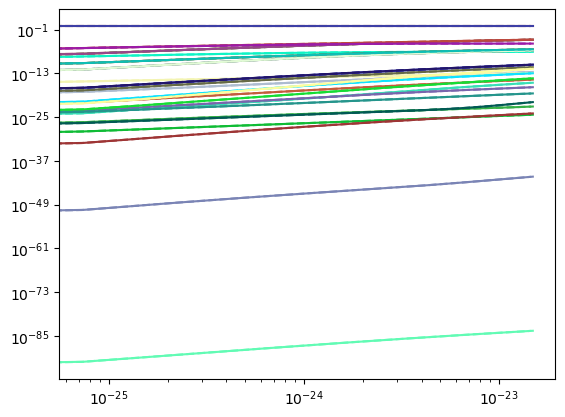

In [200]:
# compare kinetics
oconcs = og_solver.concentrations_df()
rconcs = plot_solver.concentrations_df()
for sp in rconcs.columns:
    c = [np.random.rand() for _ in range(3)]
    plt.plot(oconcs.index, oconcs[sp], color=c)
    plt.plot(rconcs.index, rconcs[sp], color=c, linestyle="--")
plt.yscale("log")
plt.xscale("log")